In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [9]:
# results = pd.read_csv("results.csv")
hand_results = pd.read_csv("hand_coded_results.csv")

In [ ]:
results['p_ap_b'] = results['p_a'] * results['p_b']
df_true = results[(results["success"] == True) & ()]
df_false = results[~(results["success"] == True)]

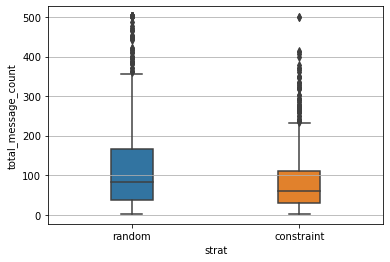

In [20]:
plt.grid()
sns.boxplot(x="strat", y="total_message_count", data=hand_results, width=0.25)


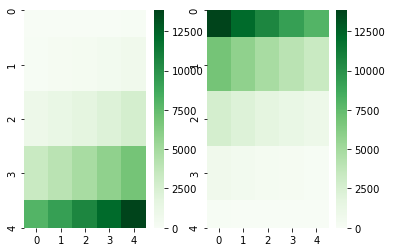

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.heatmap(np.arange(5*5).reshape(5,5) ** 3, ax=ax1,cmap="Greens")
sns.heatmap(np.flip(np.arange(5*5)).reshape(5,5) ** 3,ax=ax2,cmap="Greens")
plt.show()


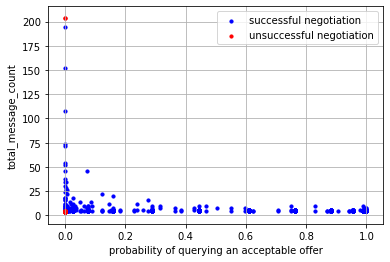

In [27]:
s = 10
plt.grid()
plt.scatter(x=df_true["p_ap_b"], y=df_true["total_message_count"],   c='b', label='successful negotiation', s=s)
plt.scatter(x=df_false["p_ap_b"], y=df_false["total_message_count"], c='r', label='unsuccessful negotiation', s=s)
plt.legend()
# plt.yscale("log")
plt.xlabel("probability of querying an acceptable offer")
plt.ylabel("total_message_count")
plt.show()